# Proyecto Final Riesgo de Crédito

*Helga Zambrana | Data Science*

### Alcance del proyecto

El riesgo de crédito analiza la probabilidad de que un prestatario no reembolse un préstamo solicitado, generando pérdidas en el prestamista. A través del desarrollo de un modelo de aprendizaje automático se busca facilitar las aprobaciones de créditos, identificando los indicadores que diferencian a los solicitantes que tienden a pagar sus deudas de quienes no.

### Objetivos del proyecto

Los objetivos de este proyecto final son:
- analizar la información disponible de los aplicantes a un préstamo e identificar las posibles variables que determinan si el solicitante no pagará el préstamo
- analizar diferentes opciones de modelos de clasificación y seleccionar el que tenga la mejor performance en predecir si el solicitante pagará o no el préstamo
- desarrollar un modelo de riesgo de crédito en Python para predecir las probabilidades de impago (PD) y asignar puntuaciones de crédito a los solicitantes existentes o potenciales

### Data Acquisition

In [1]:
%matplotlib inline
# Importar librerías

# Para operaciones básicas
import numpy as np
import pandas as pd
import pandas_profiling

# Para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Para división entre train y test
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer

# Ocultar los mensajes de advertencia
import warnings
warnings.filterwarnings('ignore')

c:\ProgramData\Miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [27]:
# Settings
# Seaborn theme
sns.set_theme()

# Matplotlib parameters
COLOR = '#ababab'
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['grid.color'] = COLOR

El dataset elegido fue Home Equity (HMEQ) de Kaggle: https://www.kaggle.com/datasets/ajay1735/hmeq-data  
HMEQ presenta información sobre las características y la morosidad de 5960 prestamistas con garantía hipotecaria.  
El dataset contiene las siguientes variables:
- BAD: Variable binaria. 1, corresponde a un prestamista con deuda impaga o con mora; 0, corresponde al candidato con los pagos de una deuda al día. Se considera morosidad cuando han pasado 90 días desde que el prestamista no ha pagado
- LOAN: Variable numérica continua. Monto en USD del préstamo solicitado
- MORTDUE: Variable numérica continua. Monto en USD adeudado de la hipoteca existente
- VALUE: Variable numérica continua. Monto en USD de la propiedad hipotecada
- REASON: Variable categórica. Motivo para solicitar el préstamo. DebtCon, corresponde a consolidación de deudas; HomeImp, corresponde a mejoras para el hogar
- JOB: Variable categórica. Profesión o categoría profesional
- YOJ: Variable numérica discreta. Cantidad de tiempo expresado en años desde que ingresó al trabajo actual
- DEROG: Variable numérica discreta. Número de informes derogatorios importantes. Es información proporcionada por una institución financiera a las agencias de crédito y se relaciona con la morosidad o la cancelación de una cuenta de una línea de crédito
- DELINQ: Variable numérica discreta. Número de líneas de crédito morosas
- CLAGE: Variable numérica discreta. Edad expresada en meses de la línea de crédito de mayor antigüedad, los modelos de puntuación consideran un mínimo de 6 meses y recién a partir de 2 años es fiable
- NINQ: Variable numérica discreta. Número de veces que ha solicitado un nuevo crédito en los últimos 2 años
- CLNO: Variable numérica discreta. Número de líneas de crédito abiertas
- DEBTINC: Variable numérica continua. Ratio deuda-ingreso (DTI), es la cantidad de ingresos brutos mensuales que una persona genera frente a la deuda que debe pagar por mes. Los prestamistas generalmente buscan ratios no mayores al 36%, aunque un DTI del 43% puede calificar para una hipoteca


In [28]:
# Leer el dataset y crear un backup
historial_credito_backup = pd.read_csv("hmeq.csv")
historial_credito = historial_credito_backup

In [29]:
# Obtener el tamaño del dataset
print('El dataset tiene ' + str(historial_credito.shape[0]) + ' filas y ' + str(historial_credito.shape[1]) + ' columnas.')

El dataset tiene 5960 filas y 13 columnas.


In [30]:
# Mostrar información sobre el nombre de columnas, cantidad de registros que no son nulos 
historial_credito.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [31]:
# Mostrar tipos de datos existentes en el dataset
historial_credito.dtypes.value_counts()

float64    9
int64      2
object     2
dtype: int64

In [32]:
# Visualizar los primeros 5 registros
historial_credito.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


#### *Valores duplicados y nulos*

In [33]:
#Verificar si existen datos duplicados en el dataset
historial_credito[historial_credito.duplicated()]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC


No existen registros duplicados en el dataset.

In [35]:
# Crear una función que muestre la información sobre valores faltantes del dataset
def get_missing_values_info(df):

    # Contar los valores faltantes en cada columna
    count_missing = df.isnull().sum()

    # Mostrar los valores faltantes como un porcentaje
    percent_missing = (100 * count_missing / df.shape[0]).round(1)

    # Crear el dataframe con los resultados 
    missing_df = pd.DataFrame({'Cantidad Datos Faltantes':count_missing,
                               'Porcentaje Datos Faltantes':percent_missing})

    # Ordenar los valores por el porcentaje de datos faltantes
    missing_df = missing_df.sort_values('Porcentaje Datos Faltantes', ascending=False)

    # Mostrar el porcentaje de columnas con valores faltantes y comparar con el número total de columnas
    missing_values_list = df.columns[df.isnull().any()].tolist()
    cols_missing_vals = len(missing_values_list)
    df_cols = df.shape[1]

    print(f'Columnas con valores faltantes: {cols_missing_vals}')
    print(f'Total de columnas: {df_cols}')
    print(f'Porcentaje de columnas con valores faltantes: {round(cols_missing_vals/df_cols*100,1)}%')

    return missing_df

get_missing_values_info(historial_credito)

Columnas con valores faltantes: 11
Total de columnas: 13
Porcentaje de columnas con valores faltantes: 84.6%


,Cantidad Datos Faltantes,Porcentaje Datos Faltantes
DEBTINC,1267,21.3
DEROG,708,11.9
DELINQ,580,9.7
MORTDUE,518,8.7
YOJ,515,8.6
NINQ,510,8.6
CLAGE,308,5.2
JOB,279,4.7
REASON,252,4.2
CLNO,222,3.7


'DEBTINC' es la variable que cuenta con mayor cantidad de valores nulos con un 21.3% del total.

<AxesSubplot:>

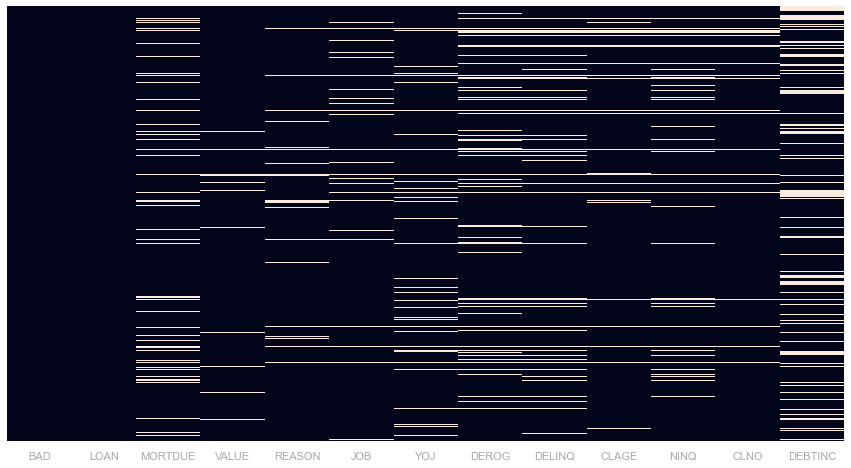

In [36]:
# Identificar los valores nulos de manera visual
sns.heatmap(historial_credito.isnull(), cbar = False, yticklabels=False)

#### *Variable target 'BAD'*

In [37]:
# Crear una función que muestre la información sobre BAD
def valoresBAD_info(df):

    # Mostrar la cantidad de registros de BAD
    count_BAD = df['BAD']. value_counts()

    # Obtener la cantidad de registros de BAD como un porcentaje
    percent_BAD = (100 * count_BAD / df.shape[0]).round(1)

    # Crear un dataframe con los resultados
    values_df = pd.DataFrame({'Cantidad':count_BAD,
                               'Porcentaje':percent_BAD})

    return values_df

valoresBAD_info(historial_credito)

,Cantidad,Porcentaje
0,4771,80.1
1,1189,19.9


Consideramos al atributo 'BAD' nuestra variable target. El mismo divide a las personas con su deuda al día (BAD = 0) de las personas con deuda morosa (BAD = 1).  
Una primera conclusión es que el dataset está desbalanceado porque solo el 19.9% del dataset representa a las personas con deuda morosa. Hay que tenerlo en cuenta al momento de aplicar el modelo de Machine Learning.

#### *División entre Train y Test*

Antes de comenzar a limpiar e imputar los datos faltantes, debemos dividir el dataset en 2 conjuntos:
- "Train", 80% del total de registros del dataset, que usaremos para entrenar nuestro modelo
- "Test", 20% del total de registros del dataset, sobre el que evaluaremos nuestro modelo entrenado

In [38]:
# Dividir aleatoriamente el dataset en train (80%) y test (20%) y mantener la distribución de cantidad de personas morosas en el test set
X = historial_credito.drop('BAD', axis=1)
y = historial_credito['BAD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)
# Mostrar la cantidad de variables independientes que se usarán para entrenar el modelo
print("Cantidad de registros en X_train: ", len(X_train))
# Mostrar la cantidad de variables independientes que se usarán para realizar predicciones y testear la precisión del modelo
print("Cantidad de registros en X_test: ", len(X_test))
# Mostrar la cantidad de variables dependientes que necesitan ser predichas por este modelo, incluyendo etiquetas de categoría contra sus variables independientes
print("Cantidad de registros en y_train: ", len(y_train))
# Mostrar la cantidad de datos con etiquetas de categoría, se utilizarán para probar la precisión entre las categorías reales y las predichas.
print("Cantidad de registros en y_test: ", len(y_test))

Cantidad de registros en X_train:  4768
Cantidad de registros en X_test:  1192
Cantidad de registros en y_train:  4768
Cantidad de registros en y_test:  1192


In [39]:
# Unir x_train y y_train en un único dataframe
train_df = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
train_df.head()

,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,BAD
609,7700,70451.00,81862.0,DebtCon,Sales,3.0,0.0,0.0,141.268671,0.0,31.0,31.681943,0
4015,21000,48735.00,71694.0,DebtCon,Other,8.0,0.0,0.0,48.498971,3.0,10.0,32.921401,1
1591,11500,63136.00,81099.0,DebtCon,Other,3.0,NaN,NaN,149.064745,NaN,35.0,28.975940,0
1127,9900,55342.00,72357.0,DebtCon,Mgr,7.0,NaN,3.0,111.998855,1.0,11.0,39.870340,0
920,9000,47350.86,105000.0,DebtCon,ProfExe,6.0,0.0,1.0,227.266667,0.0,10.0,NaN,0


### Data Wrangling + Análisis Exploratorio de Datos (EDA)

En esta sección prepararemos, limpiaremos y unificaremos los datos. Trataremos los outliers para facilitar el análisis y el modelado en profundidad.

#### *Análisis de variables categóricas*

In [40]:
# Indagar los valores únicos de las variables categóricas 'REASON' Y 'JOB'
print('Los valores únicos de la variable REASON son ' + str(train_df['REASON'].unique()))
print('Los valores únicos de la variable JOB son ' + str(train_df['JOB'].unique()))

Los valores únicos de la variable REASON son ['DebtCon' 'HomeImp' nan]
Los valores únicos de la variable JOB son ['Sales' 'Other' 'Mgr' 'ProfExe' 'Self' 'Office' nan]


In [41]:
# Mostrar la cantidad de registros correspondientes a la variable categórica 'REASON' en relación a la variable target'BAD'
train_df.groupby('BAD')['REASON'].value_counts(dropna=False)

BAD  REASON 
0    DebtCon    2534
     HomeImp    1123
     NaN         160
1    DebtCon     594
     HomeImp     322
     NaN          35
Name: REASON, dtype: int64

In [42]:
# Reemplazar los valores nulos declarándolos valores desconocidos
train_df["REASON"].fillna('ReasonUnknown',inplace=True)
train_df["JOB"].fillna('JobUnknown',inplace=True)

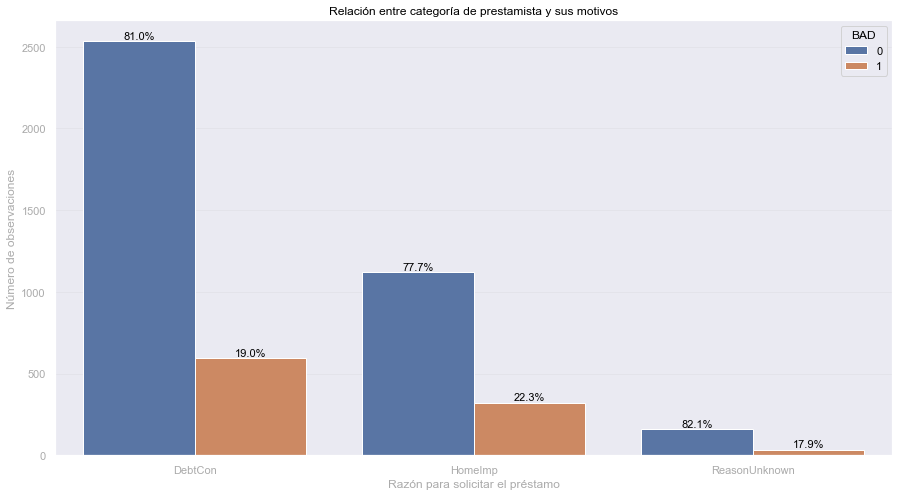

In [43]:
# Mostrar los resultados en un bar plot
def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')

ax = sns.countplot(x="REASON", 
                   hue="BAD", 
                   data=train_df)
ax.set(xlabel='Razón para solicitar el préstamo',
       ylabel='Número de observaciones',
       title = 'Relación entre categoría de prestamista y sus motivos')

percentage_above_bar_relative_to_xgroup(ax)
plt.show()

Según la variable 'REASON', 'DebtCon' (consolidación de deudas) es el motivo principal para solicitar un préstamo, entre quienes pagan o no sus deudas. A partir de la muestra, inferimos que si la razón es 'HomeImp' (mejoras del hogar), la diferencia entre quienes pagan y no pagan disminuye.

In [44]:
# Mostrar la cantidad de registros correspondientes a la variable categórica 'JOB' en relación a la variable target 'BAD' 
train_df.groupby('BAD')['JOB'].value_counts(dropna=False)

BAD  JOB       
0    Other         1479
     ProfExe        839
     Office         654
     Mgr            467
     JobUnknown     213
     Self           106
     Sales           59
1    Other          458
     ProfExe        167
     Mgr            139
     Office          93
     Self            44
     Sales           33
     JobUnknown      17
Name: JOB, dtype: int64

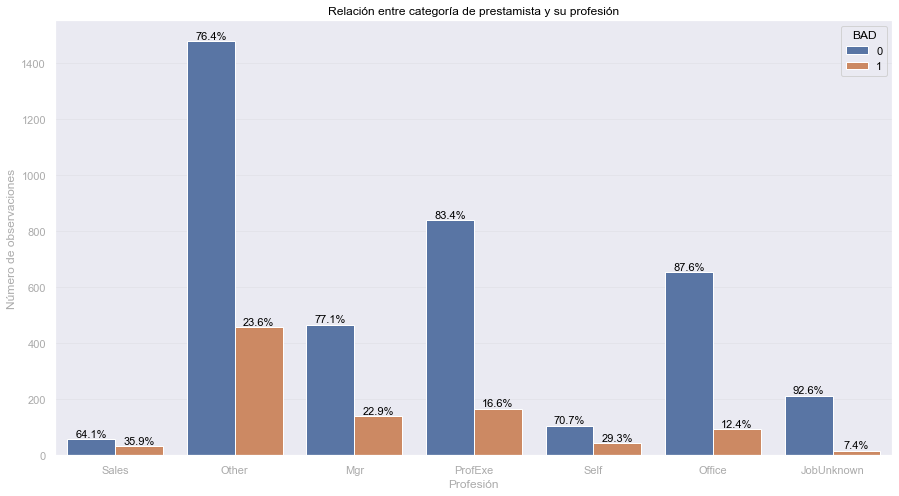

In [45]:
# Mostrar los resultados en un bar plot
def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')

ax = sns.countplot(x="JOB", hue="BAD", data=train_df)
ax.set(xlabel='Profesión',
       ylabel='Número de observaciones',
       title = 'Relación entre categoría de prestamista y su profesión')

percentage_above_bar_relative_to_xgroup(ax)
plt.show()

Según la variable 'JOB', y teniendo en cuenta la diferencia dentro de cada categoría, inferimos que la diferencia es poca entre quienes tienen su hipoteca al día y quienes no entre los profesionales de 'Sales' (Ventas) y 'Self' (Autónomos).

In [46]:
# Transformar 'JOB' y 'REASON' de variables categóricas a variables numéricas
train_df = train_df.join(pd.get_dummies(train_df["JOB"]))
train_df = train_df.join(pd.get_dummies(train_df["REASON"]))
train_df.drop(["JOB","REASON"],axis=1,inplace=True)

#### *Análisis de variables numéricas*

In [47]:
# Pasar la variable 'CLAGE' de meses a años para igualar con la unidad de medida de 'YOJ'
train_df['CLAGE'] = train_df['CLAGE'].div(12)
train_df['CLAGE']

609     11.772389
4015     4.041581
1591    12.422062
1127     9.333238
920     18.938889
          ...    
3287    14.791667
4301     2.597391
2821    26.317719
1167    16.063889
2       12.455556
Name: CLAGE, Length: 4768, dtype: float64

##### *Estadísticas descriptivas de candidatos con préstamos pagados*

In [48]:
# Filtrar los préstamos pagados a partir de la variable 'BAD'
train_df[train_df['BAD']==0].drop(['BAD'], axis=1).describe().round(4)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,JobUnknown,Mgr,Office,Other,ProfExe,Sales,Self,DebtCon,HomeImp,ReasonUnknown
count,3817.0000,3480.0000,3811.0000,3466.0000,3303.0000,3407.0000,3625.0000,3467.0000,3679.0000,3434.0000,3817.0000,3817.0000,3817.0000,3817.0000,3817.0000,3817.0000,3817.0000,3817.0000,3817.0000,3817.0000
mean,19016.4527,75237.9798,103011.4014,9.1132,0.1353,0.2480,15.5828,1.0430,21.2900,33.2830,0.0558,0.1223,0.1713,0.3875,0.2198,0.0155,0.0278,0.6639,0.2942,0.0419
std,11216.7812,44125.3172,53671.7246,7.6970,0.5181,0.6797,7.0116,1.5367,9.7419,6.8610,0.2296,0.3277,0.3769,0.4872,0.4142,0.1234,0.1643,0.4724,0.4557,0.2004
min,1700.0000,2619.0000,8000.0000,0.0000,0.0000,0.0000,0.0406,0.0000,0.0000,0.7203,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,11600.0000,47674.2500,67955.0000,3.0000,0.0000,0.0000,10.0443,0.0000,15.0000,29.0219,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,16800.0000,66916.5000,90555.0000,7.0000,0.0000,0.0000,15.0707,1.0000,20.0000,34.5363,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
75%,23600.0000,93416.7500,120713.0000,13.0000,0.0000,0.0000,19.9281,2.0000,26.0000,38.7154,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000
max,89900.0000,371003.0000,471827.0000,36.0000,6.0000,5.0000,54.1456,11.0000,56.0000,45.5698,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


##### *Estadísticas descriptivas de candidatos con préstamos morosos*

In [49]:
#Filtrar los préstamos morosos a partir de la variable 'BAD'
train_df[train_df['BAD']==1].drop(['BAD'], axis=1).describe().round(4)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,JobUnknown,Mgr,Office,Other,ProfExe,Sales,Self,DebtCon,HomeImp,ReasonUnknown
count,951.0000,867.0000,868.0000,899.0000,877.0000,889.0000,884.0000,887.0000,905.0000,329.0000,951.0000,951.0000,951.0000,951.0000,951.0000,951.0000,951.0000,951.0000,951.0000,951.0000
mean,16587.0662,67420.6777,95618.8549,8.1424,0.7138,1.2565,12.3984,1.7587,21.2254,38.7484,0.0179,0.1462,0.0978,0.4816,0.1756,0.0347,0.0463,0.6246,0.3386,0.0368
std,11081.9650,44226.2662,69354.4040,7.1805,1.4701,1.9526,7.3218,2.2296,12.0121,16.5307,0.1326,0.3535,0.2972,0.4999,0.3807,0.1831,0.2102,0.4845,0.4735,0.1884
min,1100.0000,2063.0000,8800.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5245,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,9300.0000,38850.0000,58998.7500,2.0000,0.0000,0.0000,7.8947,0.0000,13.0000,31.9837,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,14600.0000,59543.0000,81209.5000,6.0000,0.0000,0.0000,10.8472,1.0000,20.0000,38.0149,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
75%,21000.0000,84871.5000,115762.5000,12.0000,1.0000,2.0000,15.8847,2.5000,28.0000,43.1599,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000
max,77400.0000,399550.0000,855909.0000,41.0000,10.0000,15.0000,97.3528,17.0000,71.0000,203.3121,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


De las estadísticas descriptivas se pueden comenzar a perfilar algunas definiciones:

- La media de las variables en USD 'LOAN', 'MORTDUE' y 'VALUE' es mayor en las muestras de préstamos PAGADOS.
- Como es esperable, la media de la variable 'DEBTINC' (ratio de deuda-ingresos) es mayor en el caso de préstamos MOROSOS, con un posible Outlier de 203.3121.
- La media de las variables relacionadas con el historial crediticio de la persona que solicita el préstamo, que incluye 'DEROG', 'DELINQ' y 'NINQ', es mayor en el caso de los préstamos MOROSOS.
- La media de la variable 'CLNO' (líneas de crédito abiertas) es similar en ambos casos.

#### *Visualización de variables*

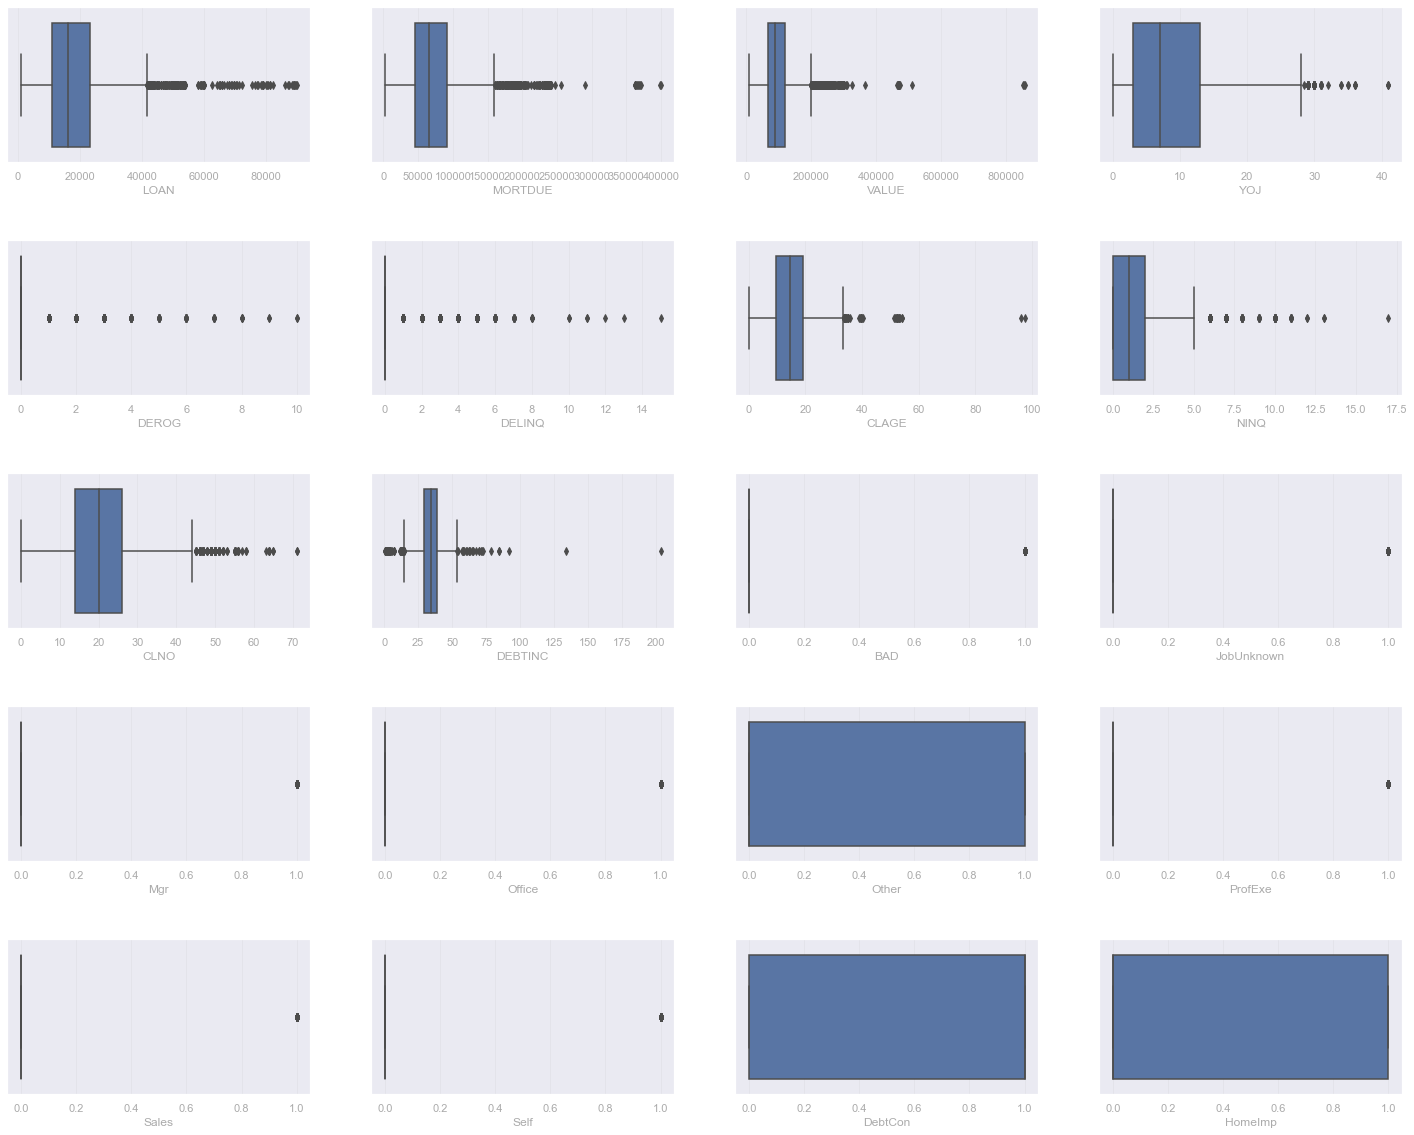

In [50]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20),)
for i,ax in zip(train_df.columns,axes.flat):
    sns.boxplot(data=train_df, x=i,ax=ax)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

<AxesSubplot:>

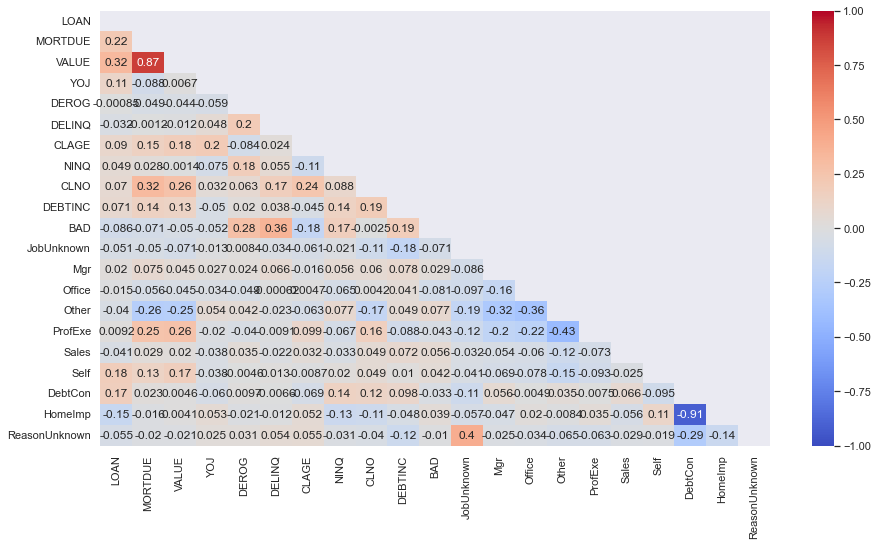

In [52]:
#Mapa de Correlación
upp_mat = np.triu(train_df.corr())

sns.heatmap(train_df.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = upp_mat)

El mapa de correlaciones puede indicar una relación predictiva a ser explotada en el modelo de clasificación. Los colores más fríos corresponden a una baja correlación, los más cálidos corresponden a una alta correlación. 

Las variables relacionadas con el historial crediticio ('DELINQ', 'DEROG', 'NINQ') son las más correlacionadas con la variable target ('BAD'). Es un indicio de que éstas serán las variables de clasificación. Estas variables también están ligeramente correlacionadas entre sí sugiriendo que la información podría ser redundante.

El monto adeudado de la hipoteca existente ('MORTDUE') o el valor de la garantía subyacente ('VALUE') no parecen estar relacionados con el estado del préstamo. De todos modos, forman otro grupo de correlación con otras variables como los Años_Crédito y el número de líneas de crédito (CLNO).